# Univariate to Univariate Prediction
**This notebook compares the current LSTM model trained on emotion data against two naive models**:

1. Mean Model: Takes the mean of all timesteps in the lookback period.
2. Learnable Weighted Mean Model: Computes a weighted mean of all previous timesteps, where the weights are learned.



### For prediction, I will explore two approaches:
1. Recursive Single Prediction: Predicts future time steps one at a time using previous prediction as input for the next prediction.
2. All-Timestep Prediction: Predicts all future timesteps in one shot.

Imports

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor') #going up several files until emili_TimeSeriesPredictor
from time_series_predictor.Data.emotionFeatureExtractor import emotionFeatureExtractor
#Modeling imports
# import tensorflow as tf
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input, Lambda, Flatten
# from tensorflow.keras.regularizers import l1, l2
# import tensorflow.keras.backend as K
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

### **Generating Synthetic Data**

**Parameters**

In [2]:
# Sine function parameters
'''
To change the number of oscillations between 1 xTrain sample and the next
Increase the sine_frequency

Alternatively, you can increase lookback
'''
sine_frequency = 0.02 #maximum frequency present is sine function

#sampling parameters
sampling_frequency = 10
delta_t = 1/sampling_frequency # time between each sample
assert sampling_frequency > 2*sine_frequency

#ML trainign data parameters
lookback = 1000
forecast = 75
stride = lookback + forecast #so no overlap

nSamples = 40
noise_lvl = 0

print(f'Time between each sample is {delta_t}')
print(f'Number of seconds of data is {delta_t*(lookback+forecast)*nSamples}')


Time between each sample is 0.1
Number of seconds of data is 4300.0


**Univariate synthetic data:**

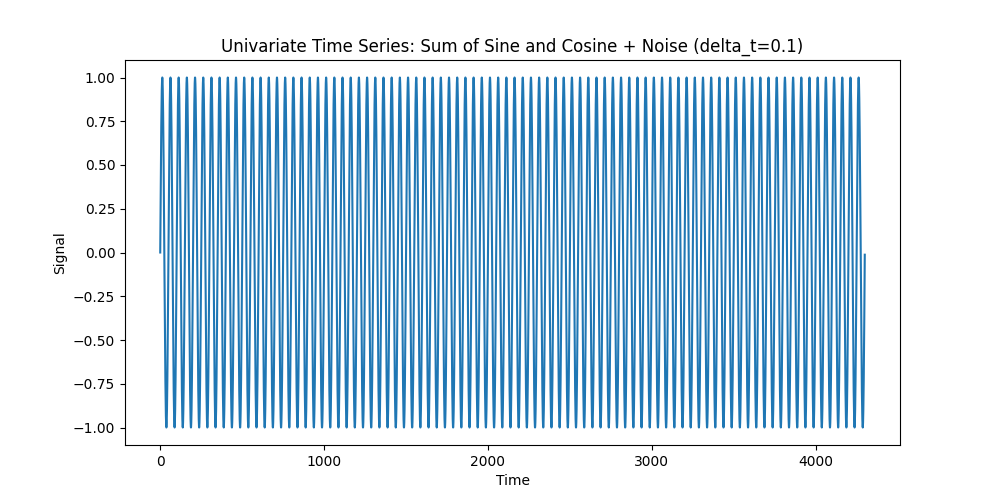

In [3]:

def gen_univariate_synthetic_data(timesteps, delta_t, frequency=0.001, noise_level=0.1):
    t = np.linspace(0, (timesteps-1)*delta_t, timesteps)

    # Generate sine wave based on frequency, where `frequency` is in Hz
    signal = (np.sin(2 * np.pi * frequency * t))
    #  + np.sin(2*np.pi*frequency*4*t - 2*np.pi*frequency/10) 
    #           - 2*np.cos(2 * np.pi * frequency/1.5 * t) +
    #            0.2*np.sin(2 * np.pi * frequency/7* t) + np.sin(2*np.pi*frequency*4*t ))
    
    # Add noise to the signal
    noise = np.random.normal(0, noise_level, timesteps)

    return t, signal + noise

t,univariate_data = gen_univariate_synthetic_data(timesteps = (lookback+forecast)*nSamples, delta_t=delta_t, noise_level=noise_lvl, 
                                                  frequency=sine_frequency)

plt.figure(figsize=(10, 5))
plt.plot(t, univariate_data)
plt.title(f"Univariate Time Series: Sum of Sine and Cosine + Noise (delta_t={delta_t})")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()

**Creating train-test-split**

In [4]:

def train_test_split(data, lookback_period, forecast_period, stride, test_split = 0.2):
    # Ensure data is a numpy array
    data = np.array(data)

    # Initialize lists to hold the segmented data
    x, y = [], []

    # Loop over the dataset and create x and y using the sliding window approach
    for i in range(0, len(data) - lookback_period - forecast_period + 1, stride):
        x.append(data[i:i + lookback_period])
        y.append(data[i + lookback_period:i + lookback_period + forecast_period])

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)

    #creating new axis so data is (#samples, timesteps, features)
    if len(np.shape(x)) == 2:
        x = x[:,:,np.newaxis]
    if len(np.shape(y)) == 2:
        y = y[:,:,np.newaxis]

    # Determine the split point for the training and testing sets
    split_idx = int(np.shape(x)[0] * (1 - test_split))

    # Split the data into training and testing sets
    x_train, x_test = x[:split_idx], x[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return x_train, y_train, x_test, y_test


xTr,yTr,xTe,yTe = train_test_split(data = univariate_data, lookback_period = lookback, forecast_period = forecast, stride = stride, 
                                   test_split=0.3)
print(xTr.shape) # (samples, length of sample = lookback, features for timestep)
print(xTe.shape)
print(yTr.shape) # (samples, length of forecast = forecast, 1) Predicting 1 feature
print(yTe.shape)

(28, 1000, 1)
(12, 1000, 1)
(28, 75, 1)
(12, 75, 1)


**Plotting the univariate data train and test samples to verify**

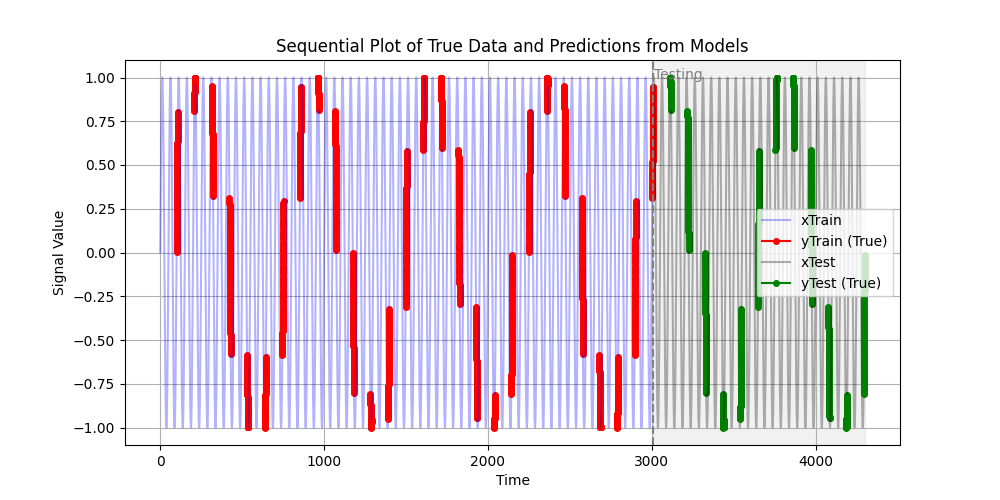

In [5]:
def plot_sequential_samples(univariate_data, x_train, y_train, x_test, y_test, model_preds_dict=None, delta_t=0.1):
    """
    Plots the original univariate data along with sequentially plotted x_train, y_train, x_test, y_test,
    and model predictions from multiple models.

    Parameters:
    - univariate_data: Original univariate time series data (1D array).
    - x_train: Training input data (2D array).
    - y_train: Training output data (2D array).
    - x_test: Testing input data (2D array).
    - y_test: Testing output data (2D array).
    - model_preds_dict: A dictionary with keys 'training' and 'testing', each containing a list of tuples
                        (model name, predictions) for training and testing.
    - delta_t: The time interval between consecutive time steps.
    """
    plt.figure(figsize=(10, 5))

    # Define consistent colors for each model
    model_colors = {
        "Weighted Average Model": "orange",
        "LSTM Model": "purple",
        # Add more models and colors here if needed
    }

    # Plot original univariate data timeline
    t_original = np.arange(len(univariate_data)) * delta_t
    
    # Plot training data (x_train and y_train) sequentially
    lookback_period = x_train.shape[1]
    forecast_period = y_train.shape[1]
    start = 0
    
    #Plotting training data
    for i in range(x_train.shape[0]):
        t_x_train = t_original[start:start + lookback_period]
        t_y_train = t_original[start + lookback_period:start + lookback_period + forecast_period]
        start += stride

        # Plot true training input and output
        plt.plot(t_x_train, x_train[i], color='blue', alpha=0.3, linestyle='-', label='xTrain' if i == 0 else '')
        plt.plot(t_y_train, y_train[i], color='red', marker='o', markersize=4, label='yTrain (True)' if i == 0 else '')

        # Plot predictions for each model on the training data
        if model_preds_dict is not None:
            for model_name, train_preds in model_preds_dict.get('training', []):
                color = model_colors.get(model_name, 'black')  # Default to black if model not in the dictionary
                t_y_pred = np.arange(start = t_y_train[0], stop = t_y_train[0] + train_preds[i].shape[0]*delta_t, step=delta_t)[:train_preds[i].shape[0]] #last slice so no 2 values
                plt.plot(t_y_pred, train_preds[i], color=color, linestyle='-', marker='o', markersize=4, label=f'{model_name} (Train Pred)' if i == 0 else '')

    # Plot testing data (x_test and y_test) sequentially
    for i in range(x_test.shape[0]):
        t_x_test = t_original[start:start + lookback_period]
        t_y_test = t_original[start + lookback_period:start + lookback_period + forecast_period]
        start += stride

        # Plot true testing input and output
        plt.plot(t_x_test, x_test[i], color='black', alpha=0.3, linestyle='-', label='xTest' if i == 0 else '')
        plt.plot(t_y_test, y_test[i], color='green', marker='o', markersize=4, label='yTest (True)' if i == 0 else '')

        # Plot predictions for each model on the testing data
        if model_preds_dict is not None:
            for model_name, test_preds in model_preds_dict.get('testing', []):
                color = model_colors.get(model_name, 'black')  # Default to black if model not in the dictionary
                t_y_pred = np.arange(start = t_y_test[0], stop = t_y_test[0] + test_preds[i].shape[0]*delta_t, step=delta_t)[:test_preds[i].shape[0]]
                plt.plot(t_y_pred, test_preds[i], color=color, linestyle='-', marker='o', markersize=4, label=f'{model_name} (Test Pred)' if i == 0 else '')

    # Define the split point for shading the testing data
    train_end_idx = len(x_train) * stride

    # Shade the testing portion
    plt.axvspan(t_original[train_end_idx], t_original[-1], color='lightgray', alpha=0.3, label=None)

    # Plot a vertical dotted line to separate training and testing data
    plt.axvline(x=t_original[train_end_idx], color='gray', linestyle='--')

    # Add the label "Testing" near the vertical line
    plt.text(t_original[train_end_idx] + 5, plt.gca().get_ylim()[1] * 0.9, 'Testing', color='gray')

    plt.title(f"Sequential Plot of True Data and Predictions from Models")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_sequential_samples(univariate_data=univariate_data, x_train=xTr, y_train=yTr, x_test=xTe, y_test=yTe, delta_t=delta_t)

# Models

**Training and Prediction Functions**

In [42]:
def train(model, xTrain, yTrain, xVal=None, yVal=None, epochs=10, batch_size=32, lr=0.001, shuffle=False):
    """
    General training function for PyTorch models.
    
    Parameters:
    - model (nn.Module): The PyTorch model to be trained.
    - xTrain (numpy.ndarray): Training data of shape (num_samples, timesteps, features).
    - yTrain (numpy.ndarray): Training labels of shape (num_samples, target_dim).
    - xVal (numpy.ndarray, optional): Validation data of shape (num_samples, timesteps, features).
    - yVal (numpy.ndarray, optional): Validation labels of shape (num_samples, target_dim).
    - epochs (int, optional): Number of epochs to train (default is 10).
    - batch_size (int, optional): Batch size (default is 32).
    - lr (float, optional): Learning rate for the optimizer (default is 0.001).
    - device (str, optional): Device to use for training ('cpu' or 'cuda'). If None, defaults to 'cpu'.
    
    Returns:
    - training_loss_history (list): History of training loss per epoch.
    - validation_loss_history (list): History of validation loss per epoch (if validation data is provided).
    """
    
    # Convert numpy arrays to PyTorch tensors and move them to the device
    xTrain = torch.from_numpy(xTrain).float()
    yTrain = torch.from_numpy(yTrain).float()
    
    if xVal is not None and yVal is not None:
        xVal = torch.from_numpy(xVal).float()
        yVal = torch.from_numpy(yVal).float()

    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Can be changed based on the task (e.g., CrossEntropyLoss for classification)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # History to store loss per epoch
    training_loss_history = []
    validation_loss_history = []

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        
        if shuffle:
            # Shuffle the data at the beginning of each epoch
            permutation = torch.randperm(xTrain.size(0))
        else:
            # If no shuffling, maintain original order
            permutation = torch.arange(xTrain.size(0))

        # Process each batch
        for i in range(0, len(xTrain), batch_size):
            indices = permutation[i:i+batch_size]
            x_batch = xTrain[indices]
            y_batch = yTrain[indices]
            
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(x_batch)
            assert(outputs.shape == y_batch.shape) #ensuring input and output sizes always match
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        # Average loss for the epoch
        training_loss_history.append(epoch_loss / len(xTrain))

        # Validation step (if provided)
        if xVal is not None and yVal is not None:
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad():  # No need to track gradients during validation
                val_outputs = model(xVal)
                val_loss = criterion(val_outputs, yVal).item()

            validation_loss_history.append(val_loss)
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss/len(xTrain):.4f}, Validation Loss: {val_loss:.4f}')
        else:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss/len(xTrain):.4f}')

    if xVal is not None and yVal is not None:
        return training_loss_history, validation_loss_history
    else:
        return training_loss_history


def predict(model, input_data):
    """
    Makes predictions using the provided PyTorch model and input data.
    
    Parameters:
    - model (nn.Module): The PyTorch model used for predictions.
    - input_data (numpy.ndarray): Input data of shape (batch_size, timesteps, features).
    
    Returns:
    - output (numpy.ndarray): Model predictions.
    """
    model.eval()  # Set the model to evaluation mode
    input_tensor = torch.from_numpy(input_data).float()  # Convert numpy to PyTorch tensor

    with torch.no_grad():  # No need to calculate gradients for predictions
        output_tensor = model(input_tensor)

    return output_tensor.numpy()  # Convert back to numpy array

def recursive_predict(model, input_data, nRecursive_predictions):
    """
    Perform recursive prediction with a PyTorch model by using the last predicted value as the next input.

    Parameters:
    - model (nn.Module): The PyTorch model used for predictions.
    - input_data (numpy.ndarray): Initial input data of shape (batch_size, timesteps, features).
    - nRecursive_predictions (int): Number of recursive predictions to make.
    
    Returns:
    - predictions (numpy.ndarray): Array of recursive predictions.
    """
    predictions = []
    current_input = torch.from_numpy(input_data).float()  # Convert to tensor

    model.eval()
    
    for _ in range(nRecursive_predictions):
        with torch.no_grad():
            # Predict the next timestep
            next_pred = model(current_input)
            predictions.append(next_pred)  # Store prediction

        # Shift the input sequence up by 1
        current_input = current_input.roll(shifts=-next_pred.shape[1], dims=1) #TODO: Only works with a single step prediction, not multiple - to fix
        # Replace the last timestep with the new prediction
        current_input[:, -next_pred.shape[1]:, :] = next_pred

    return torch.cat(predictions, dim=1)

**Average Model**

In [43]:
'''
This model requires no training
Predicts the next point as an average of the training points
Works with multivarate data
Creates an mean vector for each sample
'''

def average_model_predict(series):
    return np.mean(series, axis = 1)

# multivariate_test_data = xTr #np.repeat(xTr,repeats=3,axis = -1)
# multivariate_test_data.shape

**Weighted Average Model:**
*Weights are learned during back propagation*

In [44]:

class WeightedAverageModel(nn.Module):
    def __init__(self, timesteps, features):
        """
        Weighted Average Model where the weights across timesteps are learned.

        Parameters:
        - timesteps (int): Number of timesteps in the input sequence.
        - features (int): Number of features in each timestep.
        """
        super(WeightedAverageModel, self).__init__()
        
        # Trainable weights for the timesteps
        self.weights = nn.Parameter(torch.randn(timesteps))  # Initialized randomly
    
    def forward(self, x):
        """
        Forward pass of the weighted average model.
        
        Parameters:
        - x (torch.Tensor): Input tensor of shape (num_samples, timesteps, features).
        
        Returns:
        - torch.Tensor: Weighted average tensor of shape (num_samples, 1, features).
        """
        # Apply softmax to ensure the weights sum to 1 and are positive
        softmax_weights = F.softmax(self.weights, dim=0)  # Shape (timesteps,)
        
        # Reshape weights to (1, timesteps, 1) to broadcast them across the batch and features
        weighted_input = x * softmax_weights.view(1, -1, 1)
        
        # Sum across the timesteps to get a weighted average
        weighted_average = torch.sum(weighted_input, dim=1, keepdim=True)  # Shape (num_samples, 1, features)
        
        return weighted_average
    
# # Example usage
# multivariate_test_data = xTr #np.repeat(xTr,repeats=3,axis = -1)
# multivariate_test_data.shape
# input_data = torch.from_numpy(multivariate_test_data).float()
# print(f"Input shape: {input_data.shape}")
# weighted_average_model = WeightedAverageModel(timesteps=input_data.shape[1], features=input_data.shape[2])
# output = weighted_average_model(input_data)
# print(f"Output shape: {output.shape}")

**LSTM Model**
*Single Value Prediction*

In [45]:
class LSTMUnivariateMultiPred(nn.Module):
    def __init__(self, timesteps, features, lstm_units=64, recursive_forecast_length=1):
        """
        LSTM Model for univariate time series with multi-step or recursive prediction.

        Parameters:
        - timesteps (int): Number of timesteps in the input sequence.
        - features (int): Number of features at each timestep.
        - lstm_units (int): Number of units in the LSTM layer.
        - recursive_forecast_length (int): Number of steps to recursively predict into the future.
        """
        super(LSTMUnivariateMultiPred, self).__init__()
        
        self.timesteps = timesteps
        self.features = features
        self.lstm_units = lstm_units
        self.recursive_forecast_length = recursive_forecast_length  # Number of timesteps to predict

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=features, hidden_size=lstm_units, batch_first=True)

        # Define the fully connected layer to map LSTM outputs to the correct number of features
        self.fc = nn.Linear(lstm_units, features)

    def forward(self, x):
        """
        Forward pass of the model.
        
        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, timesteps, features).
        
        Returns:
        - torch.Tensor: Predicted output for the next `recursive_forecast_length` timesteps,
                        shape (batch_size, recursive_forecast_length, features).
        """
        
        if self.recursive_forecast_length == 1:
            # Predict only one step (standard LSTM behavior)
            lstm_out, _ = self.lstm(x)
            output = self.fc(lstm_out[:, -1, :])  # Output for the last timestep
            return output.unsqueeze(1)  # Ensure shape: (batch_size, 1, features)
        
        else:
            # Recursive prediction with access to the full original sequence
            outputs = []  # Store all predicted timesteps
            current_input = x  # Start with the full original input sequence
            
            # First, pass through the entire input to get the LSTM output for the final timestep
            lstm_out, (hn, cn) = self.lstm(current_input)
            output = self.fc(lstm_out[:, -1, :])  # First prediction based on the last LSTM output
            outputs.append(output.unsqueeze(1))  # Add the first prediction

            # Recursively predict the next timesteps
            for _ in range(1, self.recursive_forecast_length):
                # Concatenate the previous input with the new prediction along the timestep axis
                new_input = torch.cat([current_input[:, 1:, :], output.unsqueeze(1)], dim=1)
                
                # Use the concatenated input to make the next prediction
                lstm_out, (hn, cn) = self.lstm(new_input, (hn, cn))  # Use the previous hidden state (hn, cn)
                output = self.fc(lstm_out[:, -1, :])  # Predict the next output
                outputs.append(output.unsqueeze(1))  # Store the output

                # Update current_input to include the new prediction
                current_input = new_input

            # Concatenate all predictions along the timestep axis
            return torch.cat(outputs, dim=1)  # Shape: (batch_size, recursive_forecast_length, features)


# Testing Models

**Training weighted average + LSTM**

In [49]:
'''
Data is in xTr, yTr, xTe, yTe
'''
timesteps = xTr.shape[1]
features = xTr.shape[2]

weighted_average_model = WeightedAverageModel(timesteps=timesteps, features=features)
lstm_model = LSTMUnivariateMultiPred(timesteps=timesteps, features=features, lstm_units=64, recursive_forecast_length=1)
lstm_model_recursive_train = LSTMUnivariateMultiPred(timesteps=timesteps, features=features, lstm_units=64, recursive_forecast_length=forecast)
# Note recursive forecast length is to determine if the LSTM trains by predict RECURSIVELY or not

# Train the Weighted Average Model and capture the loss history
print("Training the Weighted Average Model...")
weighted_average_train_loss, weighted_average_val_loss = train(
    model=weighted_average_model,
    xTrain=xTr,
    yTrain=yTr[:,0:1,:],  
    xVal=xTe,  # Validation data
    yVal=yTe[:,0:1,:],  # Validation labels
    epochs=10,          
    batch_size=1,      
    lr=0.001,
    shuffle=False        
)

# Train the LSTM Model and capture the loss history
print("Training the LSTM Model...")
lstm_train_loss, lstm_val_loss = train(
    model=lstm_model,
    xTrain=xTr,
    yTrain=yTr[:,0:1,:],  
    xVal=xTe,  # Validation data
    yVal=yTe[:,0:1,:],  # Validation labels
    epochs=10,          
    batch_size=1,      
    lr=0.001,
    shuffle=False          
)

print("Training the Recursive LSTM Model...")
lstm_recursive_train_loss, lstm_recursive_val_loss = train(
    model=lstm_model_recursive_train,
    xTrain=xTr,
    yTrain=yTr,  
    xVal=xTe,  # Validation data
    yVal=yTe,  # Validation labels
    epochs=8,          
    batch_size=1,      
    lr=0.001,
    shuffle=False          
)

Training the Weighted Average Model...
Epoch 1/10, Training Loss: 0.5332, Validation Loss: 0.6027
Epoch 2/10, Training Loss: 0.5201, Validation Loss: 0.5878
Epoch 3/10, Training Loss: 0.5072, Validation Loss: 0.5732
Epoch 4/10, Training Loss: 0.4946, Validation Loss: 0.5589
Epoch 5/10, Training Loss: 0.4822, Validation Loss: 0.5448
Epoch 6/10, Training Loss: 0.4700, Validation Loss: 0.5311
Epoch 7/10, Training Loss: 0.4581, Validation Loss: 0.5175
Epoch 8/10, Training Loss: 0.4465, Validation Loss: 0.5043
Epoch 9/10, Training Loss: 0.4350, Validation Loss: 0.4914
Epoch 10/10, Training Loss: 0.4238, Validation Loss: 0.4787
Training the LSTM Model...
Epoch 1/10, Training Loss: 0.4028, Validation Loss: 0.3078
Epoch 2/10, Training Loss: 0.0954, Validation Loss: 0.0281
Epoch 3/10, Training Loss: 0.0230, Validation Loss: 0.0091
Epoch 4/10, Training Loss: 0.0108, Validation Loss: 0.0066
Epoch 5/10, Training Loss: 0.0071, Validation Loss: 0.0050
Epoch 6/10, Training Loss: 0.0055, Validation Lo

**Training and Validation Loss Curves**

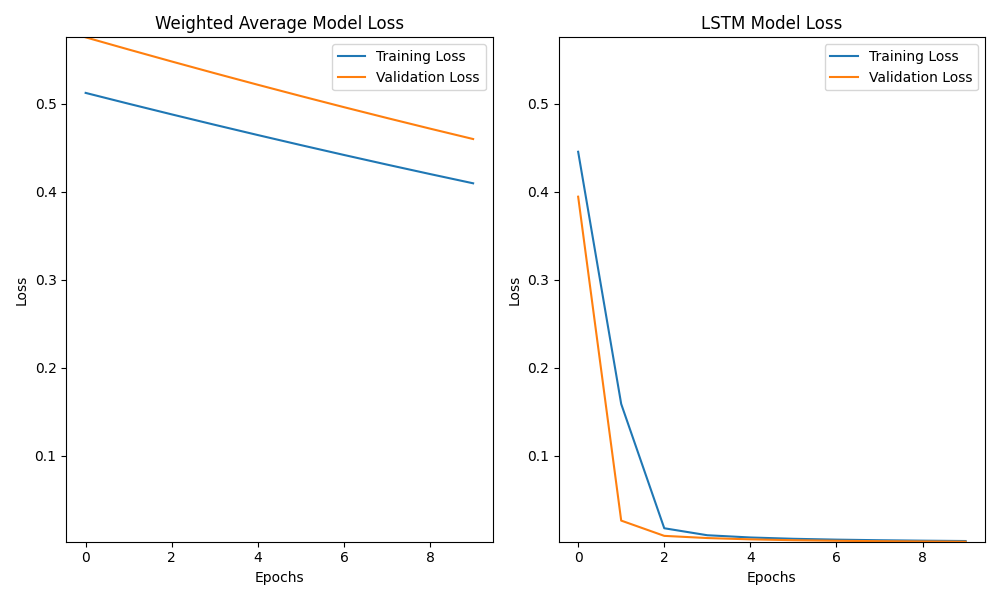

In [47]:
# Plot training and validation loss curves for the Weighted Average Model
plt.figure(figsize=(10, 6))

# Weighted Average Model loss curves
plt.subplot(2, 2, 1)
plt.plot(weighted_average_train_loss, label='Training Loss')
plt.plot(weighted_average_val_loss, label='Validation Loss')
plt.title("Weighted Average Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# LSTM Model loss curves
plt.subplot(2, 2, 2)
plt.plot(lstm_train_loss, label='Training Loss')
plt.plot(lstm_val_loss, label='Validation Loss')
plt.title("LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# LSTM recursive Model loss curves
plt.subplot(2, 2, 3)
plt.plot(lstm_recursive_train_loss, label='Training Loss')
plt.plot(lstm_recursive_val_loss, label='Validation Loss')
plt.title("Recursive Prediction Trained LSTM Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set the same y-axis limits for both plots
y_min = min(min(weighted_average_train_loss), min(weighted_average_val_loss),
            min(lstm_train_loss), min(lstm_val_loss))
y_max = max(max(weighted_average_train_loss), max(weighted_average_val_loss),
            max(lstm_train_loss), max(lstm_val_loss))

plt.subplot(2, 2, 1)
plt.ylim([y_min,y_max])  # Set y-axis limits for the first plot

plt.subplot(2, 2, 2)
plt.ylim([y_min,y_max])  # Set y-axis limits for the second plot

plt.subplot(2, 2, 3)
plt.ylim([y_min,y_max])  # Set y-axis limits for the second plot

plt.tight_layout()
plt.show()

Plotting results from both models...


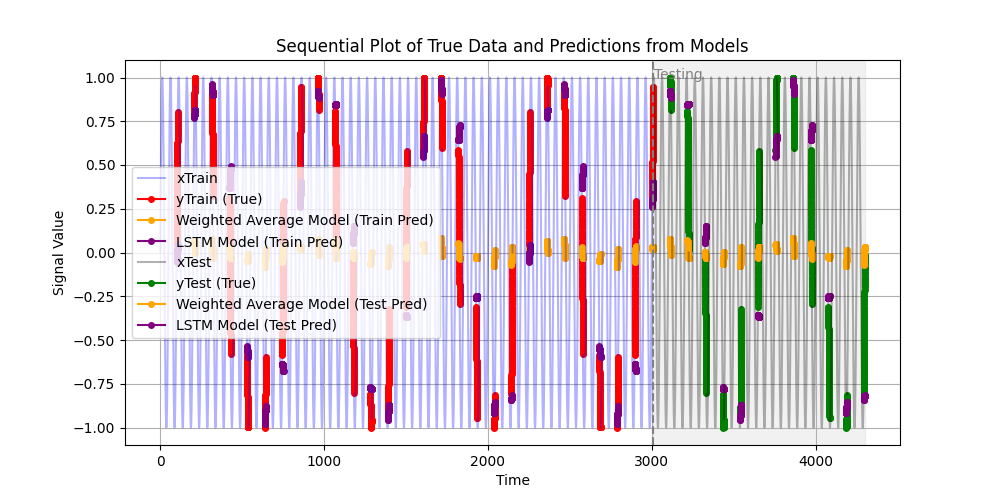

In [48]:
# Predict on training and test sets for both models
model_train_preds_weighted = recursive_predict(model=weighted_average_model, input_data=xTr, nRecursive_predictions=forecast)
model_test_preds_weighted = recursive_predict(model=weighted_average_model, input_data=xTe, nRecursive_predictions=forecast)

model_train_preds_lstm = recursive_predict(model=lstm_model, input_data=xTr, nRecursive_predictions=forecast)
model_test_preds_lstm = recursive_predict(model=lstm_model, input_data=xTe, nRecursive_predictions=forecast)

# Create a dictionary with both training and test predictions for each model
model_predictions = {
    "training": [
        ("Weighted Average Model", model_train_preds_weighted),
        ("LSTM Model", model_train_preds_lstm)
    ],
    "testing": [
        ("Weighted Average Model", model_test_preds_weighted),
        ("LSTM Model", model_test_preds_lstm)
    ]
}

# Plot predictions from both models
print("Plotting results from both models...")
plot_sequential_samples(univariate_data=univariate_data, x_train=xTr, y_train=yTr, x_test=xTe, y_test=yTe, model_preds_dict=model_predictions, delta_t=0.1)